**Ritajit Majumdar**  
Enabling Technologies Researcher @ IBM Quantum <br>
majumdar.ritajit@ibm.com

**Pedro Rivero**  
Technical Lead @ IBM Quantum <br>
pedro.rivero@ibm.com

## SPAM calibration via measurement twirling

State preparation and measurement (SPAM) error implies the scenario where the outcome of the state is $q \in \{0,1\}$, but it is incorrectly recorded as $q \oplus 1$ with probability $p$. The value of $p$ differs from qubit to qubit, and varies over time as well.<br>

In this notebook we shall calculate the SPAM fidelity of each qubit on a device by twirling the measurement, and then finding the expectation value of weight-1 $Z$ observable on that qubit. In other words,

<ol>
    <li>Twirl each qubit measurement $k$ times. In this method</li>
    <ol>
        <li>a $X$ gate is applied randomly prior to the measurement.</li>
        <li>the measurement outcome is recorded.</li>
        <li>if a $X$ gate was applied, then the measurement outcome is inverted to account for it.</li>
    </ol>
    <li>$\langle Z \rangle = (1-p) - p = 1-2p$, where $p$ is the probability of SPAM error.</li>
    <li>The ideal value of $\langle Z \rangle$ should be +1 in the absence of SPAM error, and in general $-1 \leq \langle Z \rangle \leq 1$.</li>
    <li>The probability $p$ can be calculated from the obtained expectation value to obtain the SPAM fidelity of the qubit.</li>
</ol>

## Qiskit Pattern

### Step 1: Map problem to quantum hardware native format

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()  # Credentials may be needed
backend = service.get_backend('ibm_kyiv')  # Choose your desired backend

The calibration circuit is simply a circuit where each qubit is initialized in $|0\rangle$ and is measured. The ideal outcome of each qubit is, therefore, $0$ and hence the expectation value of $\langle Z \rangle$ is `+1` for each qubit.

In [2]:
from qiskit import QuantumCircuit

num_qubits = backend.num_qubits

calibration_circuit = QuantumCircuit(num_qubits)
calibration_circuit.measure_all()

calibration_circuit.draw('mpl', fold=-1)

We define $\langle Z \rangle$ observable on each qubit. Note that we require the expectation value of each of these observables separately. Therefore, we create an array containing each of these observables.

In [3]:
from qiskit.quantum_info import SparsePauliOp

observables = [SparsePauliOp('I'*i + 'Z' + 'I'*(num_qubits-i-1)) for i in range(num_qubits)]

### Step 2: Optimize circuit and observable

In order to execute the logical circuit on actual hardware we need to express it in terms of the hardware's native gates (i.e. Instruction Set Architecture, ISA), as well as assign physical qubits for execution. This action is carried out through the process of circuit transpilation.

The calibration circuit is already hardware-native, and the placement is trivial since it encompasses the entire backend. However, we still need to define the mapping of the virtual qubits from the circuit to the physical qubits. Therefore, we just call `layout` from the `preset_pass_manager`. Note that we could still use the entire `preset_pass_manager`, but using only `layout` will speed up the process.

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
isa_calibration_circuit = pm.layout.run(calibration_circuit)

isa_calibration_circuit.draw('mpl',fold=-1)

Since the observables are already mapped to the qubits, we need not apply the circuit layout to the observables in this example.

### Step 3: Execute using Qiskit Primitives

We shall use the `EstimatorV2` primitive to run the circuit. We turn off all baseline optimizations as well as other error suppression and mitigation techniques. We also choose the number of shots and randomizations to take.

In [5]:
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions(default_shots=4096, optimization_level=0, resilience_level=0)

options.twirling.enable_measure = True
options.twirling.num_randomizations = 32

In [6]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend=backend, options=options)
pub = (isa_calibration_circuit, observables)
job = estimator.run([pub])

print(f"JOB ID: {job.job_id()}")

JOB ID: csm9q24vnxy0008d8gp0


### Step 4: Postprocess

Here we obtain the result and store the expectation value of each qubit separately. Note again that this expectation value provides us with the SPAM fidelity of each qubit. The probability of error, $p$, can be calculated as $p = (1-\langle Z \rangle)/2$. So, we obtain the SPAM fidelity (i.e. $1-p$) as $(1+\langle Z \rangle)/2$.

In [7]:
result = job.result()[0]

qubit_ev_map = {qubit: result.data.evs[qubit] for qubit in range(num_qubits)}
qubit_fidelity_map = {qubit: (1 + ev) / 2 for qubit, ev in qubit_ev_map.items()}

qubit_fidelity_map

{0: 0.990478515625,
 1: 0.985595703125,
 2: 0.995849609375,
 3: 0.903564453125,
 4: 0.99658203125,
 5: 0.8974609375,
 6: 0.99267578125,
 7: 0.99267578125,
 8: 0.99560546875,
 9: 0.980712890625,
 10: 0.9873046875,
 11: 0.99169921875,
 12: 0.98828125,
 13: 0.996826171875,
 14: 0.981689453125,
 15: 0.994873046875,
 16: 0.994384765625,
 17: 0.98779296875,
 18: 0.953125,
 19: 0.9765625,
 20: 0.948974609375,
 21: 0.98828125,
 22: 0.9912109375,
 23: 0.995849609375,
 24: 0.9921875,
 25: 0.984619140625,
 26: 0.99560546875,
 27: 0.98876953125,
 28: 0.9912109375,
 29: 0.995849609375,
 30: 0.980224609375,
 31: 0.977294921875,
 32: 0.99169921875,
 33: 0.988037109375,
 34: 0.99755859375,
 35: 0.984130859375,
 36: 0.99365234375,
 37: 0.959716796875,
 38: 0.989013671875,
 39: 0.9794921875,
 40: 0.93603515625,
 41: 0.997802734375,
 42: 0.98193359375,
 43: 0.982666015625,
 44: 0.9267578125,
 45: 0.994140625,
 46: 0.843505859375,
 47: 0.9697265625,
 48: 0.993408203125,
 49: 0.98583984375,
 50: 0.99731445

We can visualize the SPAM fidelities on the hardware coupling map. For this, we group the fidelities $f$ in ranges [$0.99 < f < 1$, $0.98 < f < 0.99$, $0.98 < f < 0.97$, $0.97 < f < 0.96$, $0.96 < f < 0.95$, $0.95 < f < 0.9$, $f < 0.9$]. Conforming to the coloring convention of qiskit, the lighter the color, the higher is the probability of error.

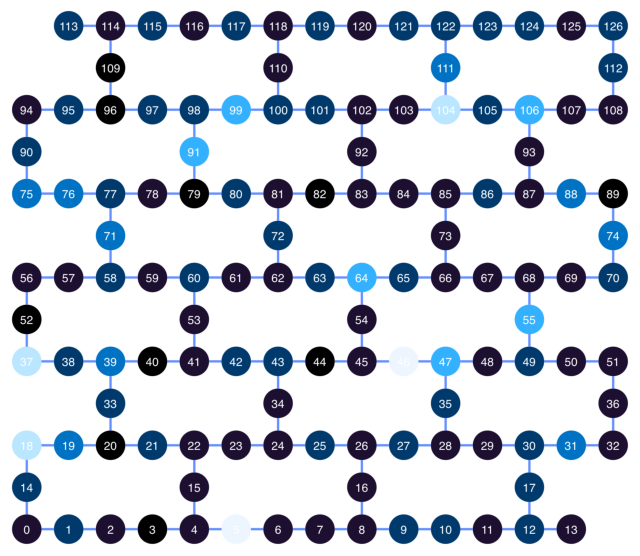

In [8]:
from qiskit.visualization import plot_gate_map

qubit_color = []
for spam_fidelity in qubit_fidelity_map.values():
    if spam_fidelity > 0.99:
        qubit_color.append("#1c0f30")
    elif spam_fidelity > 0.98:
        qubit_color.append('#003a6d')
    elif spam_fidelity > 0.97:
        qubit_color.append('#0072c3')
    elif spam_fidelity > 0.96:
        qubit_color.append('#33b1ff')
    elif spam_fidelity > 0.95:
        qubit_color.append('#bae6ff')
    elif spam_fidelity > 0.9:
        qubit_color.append('e5f6ff')
    else:
        qubit_color.append("#edf5ff")

plot_gate_map(backend, qubit_color=qubit_color, qubit_size=60, font_size=20, figsize=(8,8))

### Practice

#### Challenge 1

Determine the outlier qubits in terms of SPAM error. For example, in the above run, qubit 46, having a SPAM fidelity of $\sim 0.84$, is clearly an outlier since most of the other qubits have a SPAM fidelity $\sim 0.97-0.99$. Use some statistical technique (e.g. <a href='https://en.wikipedia.org/wiki/Standard_score'>Z-score</a>) to determine the outlier qubits.

#### Challenge 2

In this notebook, we used twirling followed by calculation of weight-1 Z observable to calculate SPAM fidelity. However, SPAM fidelity can also be determined by separately executing circuits where the qubits are initialized in $|0\rangle$ and $|1\rangle$. From these, we obtain the separate probabilities $p(q|q \oplus 1)$, $q \in \{0,1\}$, and the SPAM fidelity can be determined by averaging these two values.<br>

Next, we use this method to determine $p(0|1)$ and $p(1|0)$ for a particular qubit.

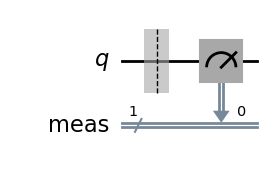

In [9]:
zero_calibration = QuantumCircuit(1)
zero_calibration.measure_all()

zero_calibration.draw('mpl')

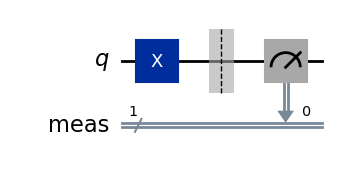

In [10]:

one_calibration = QuantumCircuit(1)
one_calibration.x(0)
one_calibration.measure_all()

one_calibration.draw('mpl')

Now we transpile the circuits by setting the target qubit index as the layout.

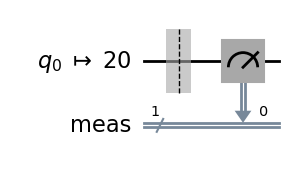

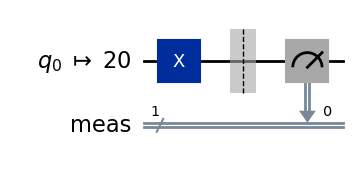

In [11]:
QUBIT_IDX = 20

pm_calibration = generate_preset_pass_manager(
    optimization_level=0, backend=backend, initial_layout=[QUBIT_IDX]
)

isa_calibration_circuits = pm_calibration.run([zero_calibration, one_calibration])

display(isa_calibration_circuits[0].draw('mpl', fold=-1, idle_wires=False))
display(isa_calibration_circuits[1].draw('mpl', fold=-1, idle_wires=False))

Since we require the probability distribution here, we shall invoke the Sampler primitive.

In [12]:
from qiskit_ibm_runtime import SamplerV2, SamplerOptions

options = SamplerOptions(default_shots=4096)
options.twirling.enable_measure = False

sampler = SamplerV2(backend=backend, options=options)
calibration_job = sampler.run(isa_calibration_circuits)

print(f"CALIBRATION JOB ID: {calibration_job.job_id()}")

CALIBRATION JOB ID: csm9zh61k2e0008p13c0


In [13]:
zero_calibration_result = calibration_job.result()[0].data.meas.get_counts()
shots = sum(zero_calibration_result.values())
p10 = zero_calibration_result['1']/shots
print(f'p(1|0) = {p10}')

one_calibration_result = calibration_job.result()[1].data.meas.get_counts()
shots = sum(one_calibration_result.values())
p01 = one_calibration_result['0']/shots
print(f'p(0|1) = {p01}')

p(1|0) = 0.011962890625
p(0|1) = 0.05419921875


Now, we can obtain the `spam_fidelity` by obtaining the average of $p(0|1)$ and $p(1|0)$.

In [14]:
average_p = (p10 + p01)/2
spam_fidelity_calibration = 1 - average_p

print(
    f'SPAM fidelity of qubit {QUBIT_IDX} '
    f'as obtained without twirling is {spam_fidelity_calibration}'
)

SPAM fidelity of qubit 20 as obtained without twirling is 0.9669189453125


We can obtain the same SPAM fidelity without twirling from backend calibration data as well. This will provide the same data as determined during the last backend calibration.

In [15]:
p01_backend = backend.properties().qubit_property(QUBIT_IDX, 'prob_meas0_prep1')[0]
p10_backend = backend.properties().qubit_property(QUBIT_IDX, 'prob_meas1_prep0')[0]

print(f'p(0|1) of qubit {QUBIT_IDX} as obtained from backend properties is {p01_backend}')
print(f'p(1|0) of qubit {QUBIT_IDX} as obtained from backend properties is {p10_backend}')

p(0|1) of qubit 20 as obtained from backend properties is 0.030000000000000027
p(1|0) of qubit 20 as obtained from backend properties is 0.0212


Whose average is reported in the backend properties as well as the _"readout error"_ for the qubit:

In [16]:
spam_fidelity_backend = 1 - backend.properties().readout_error(QUBIT_IDX)
print(
    f'SPAM fidelity of qubit {QUBIT_IDX} '
    f'as obtained from backend properties is {spam_fidelity_backend}'
)

SPAM fidelity of qubit 20 as obtained from backend properties is 0.9743999999999999


We note that the three SPAM fidelities are slightly different. A few observations are

<ol>
    <li>$p(0|1) > p(1|0)$. This is primarily because the probability of obtaining $0$ when the actual outcome is $1$ is affected both by measurement error and damping error.</li>
    <li>Twirling removes the asymmetry in the values $p(0|1)$ and $p(1|0)$, and creates a symmetric channel.</li>
    <li>Quality of the qubit changes over time. The values of SPAM fidelity obtained from the calibration data may be slightly outdated. Hence we obtain a slightly different result when we run the calibration circuits ourselved.</li>
</ol>

<BarContainer object of 3 artists>

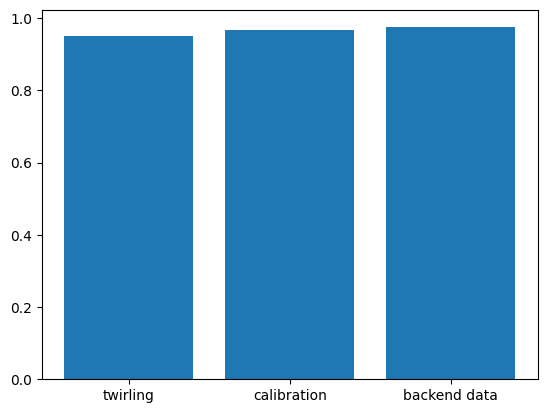

In [17]:
import matplotlib.pyplot as plt

methods = ['twirling', 'calibration', 'backend data']
values = [qubit_fidelity_map[QUBIT_IDX], spam_fidelity_calibration, spam_fidelity_backend]

plt.bar(methods, values)

**Question**: Repeat the two types of calibrations, and obtain the backend calibration data and plot the `bar graph` for each qubit.<br>

**Hint**: You don't need a separate calibration circuit for each qubit when determining $p(0|1)$ and $p(1|0)$. You can run calibration circuit for all the qubits simultaneously, and obtain the data for each qubit by marginalizing over the others.

#### Challenge 3

We consider a low-depth mirror circuit so that: 
1. SPAM errors are most dominant ones when obtaining the noisy outcome
2. Expectation value is +1 for any $Z$ type observable


In [18]:
from qiskit.circuit import Parameter

def create_low_depth_mirrored_circuit(num_qubits: int) -> QuantumCircuit:
    assert num_qubits%2 == 0, "Even number of qubits is expected"
    
    qc = QuantumCircuit(num_qubits)
    theta = Parameter("θ")
    
    qc.rx(theta, range(num_qubits))

    for i in range(0,num_qubits,2):
        qc.cx(i,i+1)

    for i in range(1,num_qubits-1,2):
        qc.cx(i,i+1)

    qc_inv = qc.inverse()
    qc.barrier()
    qc.compose(qc_inv, inplace=True)

    return qc

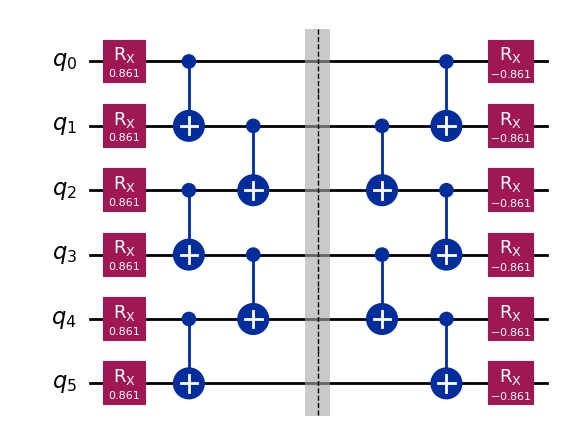

In [19]:
from numpy import pi
from numpy.random import default_rng

num_qubits = 6
circuit = create_low_depth_mirrored_circuit(num_qubits)

rng = default_rng(seed=0)
parameter_values = rng.uniform(-pi, pi, size=circuit.num_parameters)

circuit.assign_parameters(parameter_values, inplace=True)
circuit.draw('mpl', fold=-1)

We fix the observable to be the average of all weight-1 $Z$ type observable.

In [20]:
from qiskit.quantum_info import SparsePauliOp

paulis = ['I'*i + 'Z' + 'I'*(num_qubits-i-1) for i in range(num_qubits)]
coeffs = 1/len(paulis)

observable = SparsePauliOp(paulis, coeffs)
print(observable)

SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])


##### Transpilation by defining own layout

Let us first convert the circuit into basis gates without fixing any particular layout

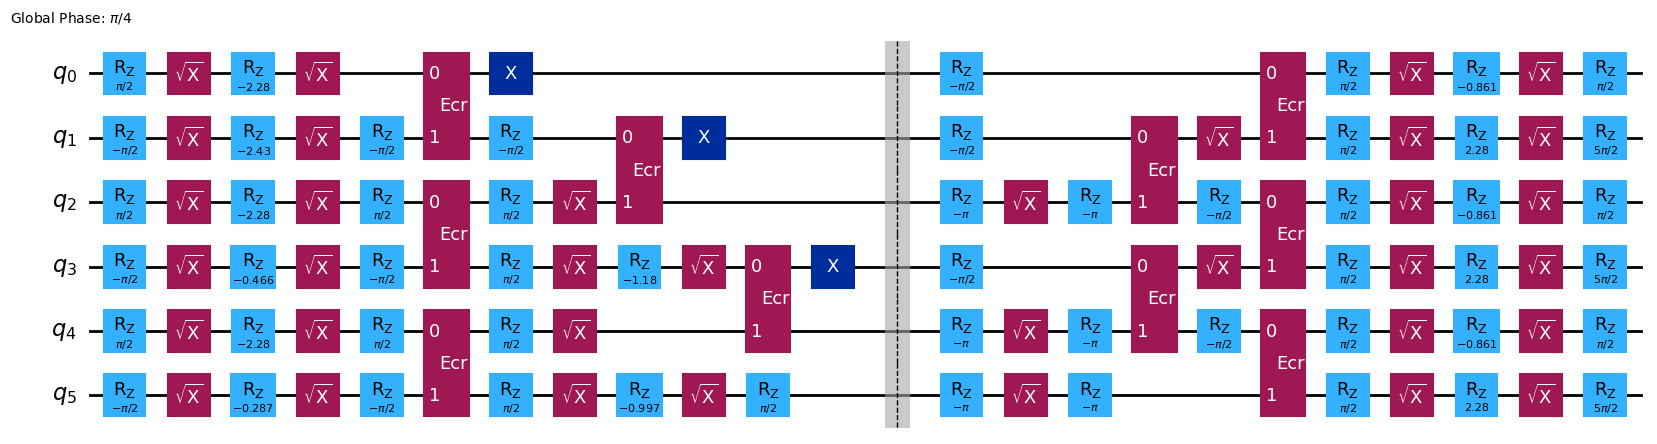

In [21]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(
    optimization_level=3, basis_gates=backend.configuration().basis_gates, seed_transpiler=42
)
basis_circuit = pm.run(circuit)

basis_circuit.draw('mpl', fold=-1)

Now, let us consider two layouts: $l_1 = [46,47,48,49,50,51]$ and $l_2 = [103,104,105,106,107,108]$. We can visualize the two layouts using `plot_gate_map` function from `qiskit_visualization`.

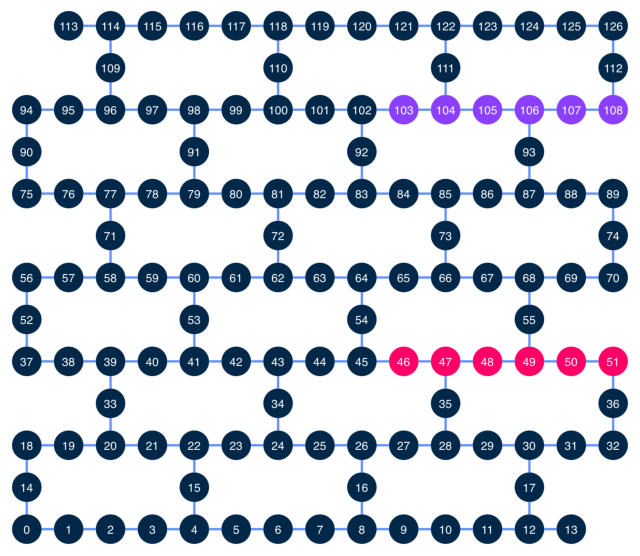

In [22]:
l1 = [46,47,48,49,50,51]
l2 = [103,104,105,106,107,108]

qubit_color = []
for i in range(backend.num_qubits):
    if i in l1:
        qubit_color.append("#ff0066")
    elif i in l2:
        qubit_color.append('#8a3ffc')
    else:
        qubit_color.append("#012749")

plot_gate_map(backend, qubit_color=qubit_color, qubit_size=60, font_size=20, figsize=(8,8))

We first note the SPAM fidelity of both the layouts.

In [24]:
from numpy import mean

print(f'Average SPAM fidelity of layout l1 is {mean([qubit_fidelity_map[qubit] for qubit in l1])}')
print(f'Average SPAM fidelity of layout l2 is {mean([qubit_fidelity_map[qubit] for qubit in l2])}')

Average SPAM fidelity of layout l1 is 0.9637451171875
Average SPAM fidelity of layout l2 is 0.9818929036458334


The SPAM fidelity of l1 is worse than that of layout 2. Therefore, we can expect that the expectation value obtained when the circuit is transpiled on the layout layout 1 should be worse than that on layout 2. We also need to apply the corresponding layouts to the observable.

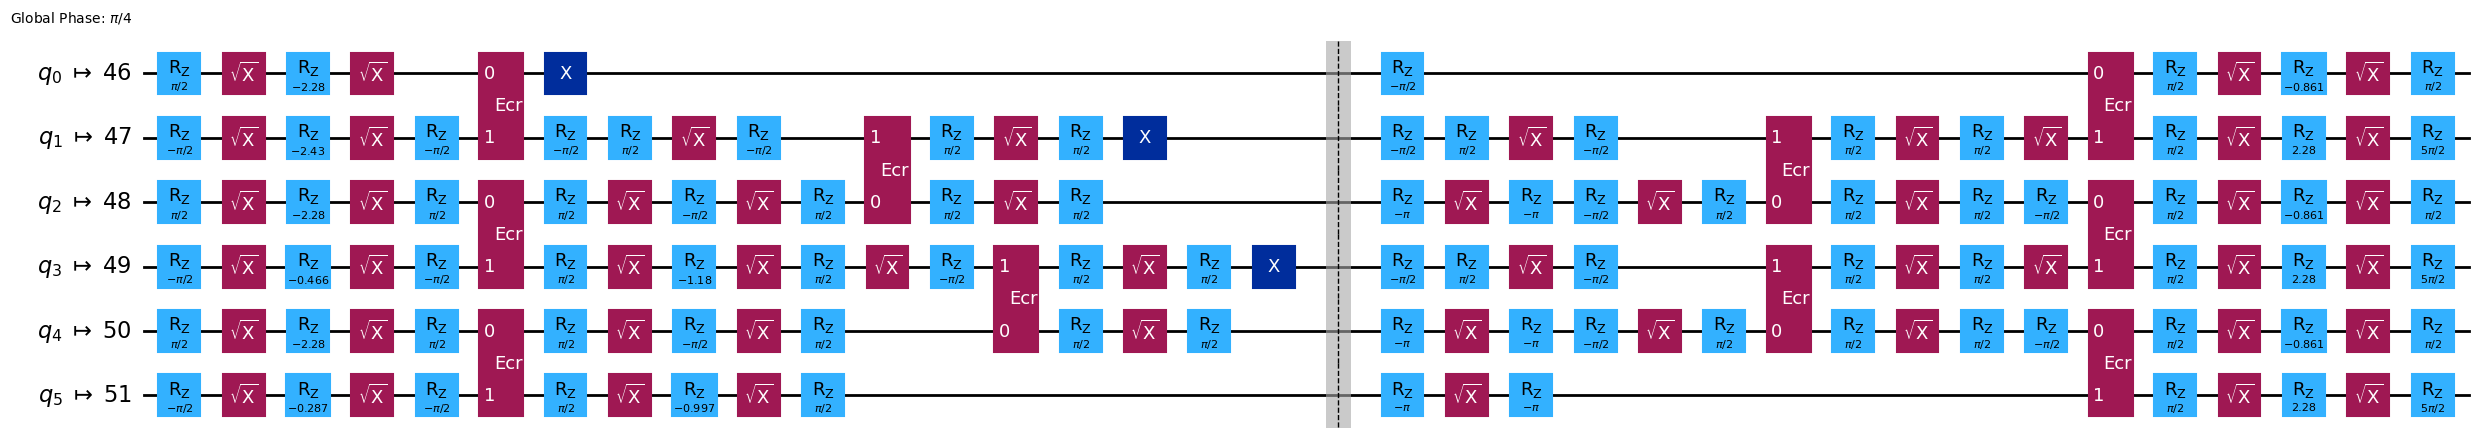

In [25]:
pm_l1 = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=l1)
isa_circuit_l1 = pm_l1.run(basis_circuit)

isa_observable_l1 = observable.apply_layout(isa_circuit_l1.layout)

isa_circuit_l1.draw('mpl', fold=-1, idle_wires=False)

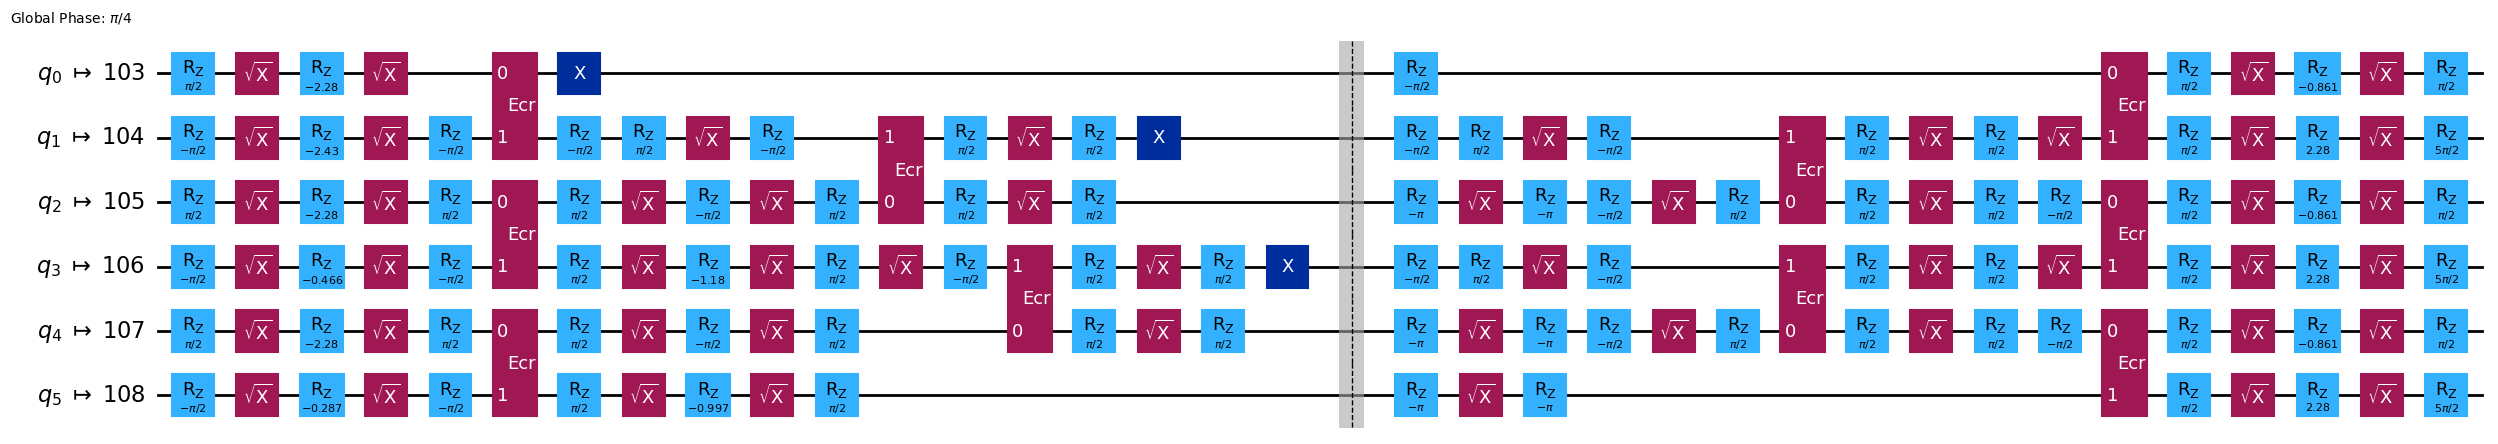

In [26]:
pm_l2 = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=l2)
isa_circuit_l2 = pm_l2.run(basis_circuit)

isa_observable_l2 = observable.apply_layout(isa_circuit_l2.layout)

isa_circuit_l2.draw('mpl', fold=-1, idle_wires=False)

Now we execute both the circuits on an estimator primitive. We shall not use any mitigation or suppression for this experiment.

In [27]:
options = EstimatorOptions(default_shots=4096, optimization_level=0, resilience_level=0)
estimator = EstimatorV2(backend=backend, options=options)
job = estimator.run([(isa_circuit_l1, isa_observable_l1),(isa_circuit_l2, isa_observable_l2)])

print(f"JOB ID: {job.job_id()}")

JOB ID: csma0sb1k2e0008p13eg


In [28]:
expval_l1 = job.result()[0].data.evs
expval_l2 = job.result()[1].data.evs

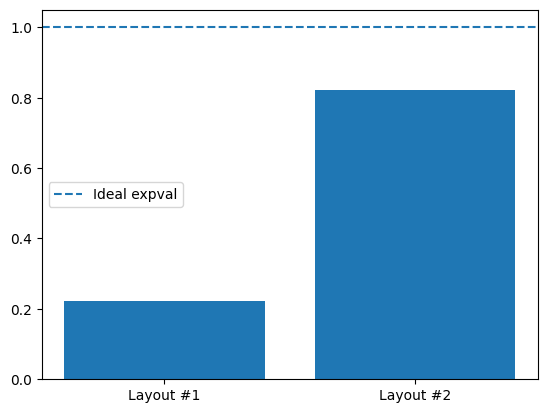

In [29]:
import matplotlib.pyplot as plt

methods = ['Layout #1', 'Layout #2']
mean_values = [expval_l1, expval_l2]

plt.bar(methods, mean_values)
plt.axhline(y = 1, linestyle = '--', label='Ideal expval')
plt.legend()

plt.show()

**Inference**: Note that for this study no suppression or mitigation technique was used. However, the selection of layout leads to a non-trivial difference in the obtained expectation value.

**Question**: Select 10 different layouts, and calculate the mean SPAM fidelity of each. 

<ol>
    <li>Run the same circuit on each layout, and report the expectation value.</li>
    <li>Draw a plot on the variation in the expectation value with the variation in the average SPAM fidelity of each layout</li>
    <li>Determine the nature of the curve of the degradation in expectation value vs average SPAM fidelity - is it linear, polynomial, or exponential?</li>
</ol>

#### Challenge 4

<ol>
    <li>Repeat the exercise of Challenge 3 for circuits with different number of qubits. Does the nature of the degradation curve remains same with increase in qubit counts?</li>
    <li>Vary the depth of the circuit (for example, increase the number of CNOT layers in the example circuit), and repeat the same experiment. Does the nature of the degradation curve remains the same with increase in depth?</li>
</ol>